Question: Using the Student Alcohol Consumption dataset, preprocess the data (e.g., encode categorical features, scale numeric ones), then build and compare Logistic Regression and K-Nearest Neighbors (KNN) models to predict whether a student's final grade (G3) is pass or fail (binary classification).

Answer: Loading and exploring the uploaded CSV, preprocessing, training Logistic Regression and KNN, and comparing their performance. The outputs (tables and metrics) will be displayed below.

Importing all libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

1. Loading dataset: "student-mat.csv"

In [32]:
df = pd.read_csv("student-mat.csv", sep=";")

2. Displaying basic information

In [33]:
print("Dataset shape:", df.shape)
print("\nFirst 6 rows:")
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("student_head", df.head(6))
except Exception as e:
    print(df.head(6))

print("\nColumns and dtypes:\n")
print(df.dtypes)

print("\nSummary statistics for numeric columns:\n")
print(df.describe().round(3))

Dataset shape: (395, 33)

First 6 rows:
  school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4   at_home   teacher   
1     GP   F   17       U     GT3       T     1     1   at_home     other   
2     GP   F   15       U     LE3       T     1     1   at_home     other   
3     GP   F   15       U     GT3       T     4     2    health  services   
4     GP   F   16       U     GT3       T     3     3     other     other   
5     GP   M   16       U     LE3       T     4     3  services     other   

   ... famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0  ...      4        3      4     1     1      3        6   5   6   6  
1  ...      5        3      3     1     1      3        4   5   5   6  
2  ...      4        3      2     2     3      3       10   7   8  10  
3  ...      3        2      2     1     1      5        2  15  14  15  
4  ...      4        3      2     1     2      5        4   

3. Creating binary target: Pass (G3 >= 10) / Fail (G3 < 10)

In [34]:
df["pass"] = (df["G3"] >= 10).astype(int)

4. Droping grade columns to avoid leakage


In [35]:
df_model = df.drop(["G1", "G2", "G3"], axis=1).copy()

5. Identifying categorical and numeric features

In [37]:
cat_cols = df_model.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()

if "pass" in num_cols:
    num_cols.remove("pass")

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numeric columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


6. Preparing X and y, split

In [38]:
X = df_model.drop("pass", axis=1)
y = df_model["pass"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (316, 30) (79, 30)


7. Preprocessor

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

8. Logistic Regression Pipeline

In [40]:
log_reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1500, random_state=42))
])

log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))


=== Logistic Regression Results ===
Accuracy: 0.6582278481012658
Confusion Matrix:
 [[ 9 17]
 [10 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.35      0.40        26
           1       0.72      0.81      0.76        53

    accuracy                           0.66        79
   macro avg       0.60      0.58      0.58        79
weighted avg       0.64      0.66      0.64        79



9. KNN Pipeline (default k=5 first)

In [41]:
knn_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("\n=== KNN (k=5) Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


=== KNN (k=5) Results ===
Accuracy: 0.5822784810126582
Confusion Matrix:
 [[ 5 21]
 [12 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.19      0.23        26
           1       0.66      0.77      0.71        53

    accuracy                           0.58        79
   macro avg       0.48      0.48      0.47        79
weighted avg       0.54      0.58      0.55        79



10. Tune best k (Optional) 


Best k: 14 with accuracy: 0.658


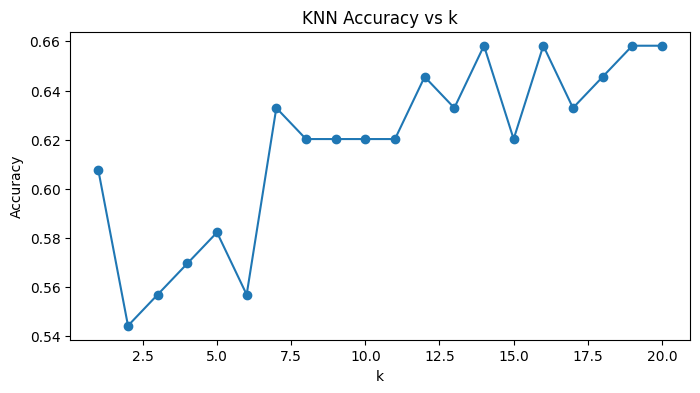

In [42]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X_train, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test))
    accuracies.append(acc)

best_k = k_values[int(np.argmax(accuracies))]
best_acc = max(accuracies)

print(f"\nBest k: {best_k} with accuracy: {best_acc:.3f}")

plt.plot(k_values, accuracies, marker="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k")
plt.show()

So It covers:

Load & target creation (pass from G3)

Leakage prevention (drop G1, G2, G3)

Feature identification (categorical vs numeric)

Train/test split (stratified)

Preprocessing (scaling numerics + one-hot encoding categoricals with ColumnTransformer)

Logistic Regression pipeline (with accuracy, confusion matrix, classification report)

KNN pipeline (same metrics)

Hyperparameter tuning for K (loop k=1..20 + accuracy plot)